# Milestone 1: Dengue Investigation
This research have been done by Elena María Ruiz and Raúl Bernalte for the subject Machine Learning Techniques at UCLM.

The purpose of this research is to determine and predict Dengue spread phenomenon. To reach this objective, we are going to have a data source from the web page of Driven Data.

---

This data has the following features:

> 1.  City and date indicators

* ``city`` – City abbreviations: sj for San Juan and iq for Iquitos
* ``week_start_date`` – Date given in yyyy-mm-dd format

> 2.  NOAA's GHCN daily climate data weather station measurements

* ``station_max_temp_c`` – Maximum temperature
* ``station_min_temp_c`` – Minimum temperature
* ``station_avg_temp_c`` – Average temperature
* ``station_precip_mm`` – Total precipitation
* ``station_diur_temp_rng_c`` – Diurnal temperature range

> 3.  PERSIANN satellite precipitation measurements (0.25x0.25 degree scale)

* ``precipitation_amt_mm`` – Total precipitation

> 4.  NOAA's NCEP Climate Forecast System Reanalysis measurements (0.5x0.5 degree scale)

* ``reanalysis_sat_precip_amt_mm`` – Total precipitation
* ``reanalysis_dew_point_temp_k`` – Mean dew point temperature
* ``reanalysis_air_temp_k`` – Mean air temperature
* ``reanalysis_relative_humidity_percent`` – Mean relative humidity
* ``reanalysis_specific_humidity_g_per_kg`` – Mean specific humidity
* ``reanalysis_precip_amt_kg_per_m2`` – Total precipitation
* ``reanalysis_max_air_temp_k`` – Maximum air temperature
* ``reanalysis_min_air_temp_k`` – Minimum air temperature
* ``reanalysis_avg_temp_k`` – Average air temperature
* ``reanalysis_tdtr_k`` – Diurnal temperature range

> 5.  Satellite vegetation - Normalized difference vegetation index (NDVI) - NOAA's CDR Normalized Difference Vegetation Index (0.5x0.5 degree scale) measurements

* ``ndvi_se`` – Pixel southeast of city centroid
* ``ndvi_sw`` – Pixel southwest of city centroid
* ``ndvi_ne`` – Pixel northeast of city centroid
* ``ndvi_nw`` – Pixel northwest of city centroid

## Initialization

First of all we are going to import all the Python libraries normally used in data science.

In [74]:
# data load and manipulation
from google.colab import files
import io
# dataframes library
import pandas as pd
# visualization 
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
# basic operations
import numpy as np
import itertools

#preprocessing
from sklearn import preprocessing
#PCA
from sklearn.decomposition import PCA
#DBSCAN
import sklearn.neighbors
from sklearn.neighbors import kneighbors_graph
from sklearn.cluster import DBSCAN
#K-means
from sklearn.cluster import KMeans
from sklearn import metrics
#Hierarchical clustering
from scipy import cluster

This function is used por obtain a dataframe from a csv file, in which we can determine the columns we want.

In [75]:
def upload_files (index_fields):
  uploaded = files.upload()
  for fn in uploaded.keys():
    print('User uploaded file "{name}" with length {length} bytes'.format(
        name=fn, length=len(uploaded[fn])))
    df = pd.read_csv(io.StringIO(uploaded[fn].decode('utf-8')), index_col = index_fields)
    return df

In [76]:
train = upload_files([])
train.head()




Saving dengue_features_train.csv to dengue_features_train (1).csv
User uploaded file "dengue_features_train.csv" with length 287139 bytes


,city,year,weekofyear,week_start_date,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,reanalysis_avg_temp_k,reanalysis_dew_point_temp_k,reanalysis_max_air_temp_k,reanalysis_min_air_temp_k,reanalysis_precip_amt_kg_per_m2,reanalysis_relative_humidity_percent,reanalysis_sat_precip_amt_mm,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm
0,sj,1990,18,1990-04-30,0.122600,0.103725,0.198483,0.177617,12.42,297.572857,297.742857,292.414286,299.8,295.9,32.00,73.365714,12.42,14.012857,2.628571,25.442857,6.900000,29.4,20.0,16.0
1,sj,1990,19,1990-05-07,0.169900,0.142175,0.162357,0.155486,22.82,298.211429,298.442857,293.951429,300.9,296.4,17.94,77.368571,22.82,15.372857,2.371429,26.714286,6.371429,31.7,22.2,8.6
2,sj,1990,20,1990-05-14,0.032250,0.172967,0.157200,0.170843,34.54,298.781429,298.878571,295.434286,300.5,297.3,26.10,82.052857,34.54,16.848571,2.300000,26.714286,6.485714,32.2,22.8,41.4
3,sj,1990,21,1990-05-21,0.128633,0.245067,0.227557,0.235886,15.36,298.987143,299.228571,295.310000,301.4,297.0,13.90,80.337143,15.36,16.672857,2.428571,27.471429,6.771429,33.3,23.3,4.0
4,sj,1990,22,1990-05-28,0.196200,0.262200,0.251200,0.247340,7.52,299.518571,299.664286,295.821429,301.9,297.5,12.20,80.460000,7.52,17.210000,3.014286,28.942857,9.371429,35.0,23.9,5.8


In our case, we are going to train our model only with the weekly data from 2004 to 2010 at San Juan city.

In [77]:
filter_data=train[(train['year'] >= 2004) & (train['year'] <= 2010) & (train['city']=='sj')]
filter_data.head()

,city,year,weekofyear,week_start_date,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,reanalysis_avg_temp_k,reanalysis_dew_point_temp_k,reanalysis_max_air_temp_k,reanalysis_min_air_temp_k,reanalysis_precip_amt_kg_per_m2,reanalysis_relative_humidity_percent,reanalysis_sat_precip_amt_mm,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm
711,sj,2004,1,2004-01-01,-0.26830,-0.123700,0.223757,0.176543,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
712,sj,2004,2,2004-01-08,-0.07310,0.017200,0.214729,0.222443,0.00,297.648571,297.571429,292.374286,299.3,296.1,20.7,72.577143,0.00,13.881429,2.028571,24.385714,5.557143,27.8,20.6,15.6
713,sj,2004,3,2004-01-15,NaN,0.002600,0.282100,0.289900,36.07,297.800000,297.971429,293.895714,299.5,296.5,20.2,78.942857,36.07,15.257143,2.171429,24.342857,5.957143,28.3,20.0,23.7
714,sj,2004,4,2004-01-22,-0.18635,-0.178625,-0.015533,0.010250,0.00,297.728571,298.107143,293.665714,300.2,295.7,1.1,78.264286,0.00,15.061429,3.042857,24.528571,6.100000,27.8,20.6,10.2
715,sj,2004,5,2004-01-29,-0.05350,-0.108000,0.236257,0.280414,0.00,297.560000,297.600000,292.878571,300.0,295.8,2.0,75.422857,0.00,14.390000,2.457143,24.628571,6.200000,28.9,20.0,1.8


## Preprocessing

We have to delete the columns ``city`` and ``week_start_date``. This data is not determinant information as rows are already ordered by time (``week_start_date`` is implicit by the columns of ``year`` and ``weekofyear``, so it is redundant and we don't need it for our model.

In [78]:
filter_data = filter_data.drop(['city', 'week_start_date'], axis=1)

In [79]:
print(filter_data.shape)
filter_data.head()

(225, 22)


,year,weekofyear,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,reanalysis_avg_temp_k,reanalysis_dew_point_temp_k,reanalysis_max_air_temp_k,reanalysis_min_air_temp_k,reanalysis_precip_amt_kg_per_m2,reanalysis_relative_humidity_percent,reanalysis_sat_precip_amt_mm,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm
711,2004,1,-0.26830,-0.123700,0.223757,0.176543,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
712,2004,2,-0.07310,0.017200,0.214729,0.222443,0.00,297.648571,297.571429,292.374286,299.3,296.1,20.7,72.577143,0.00,13.881429,2.028571,24.385714,5.557143,27.8,20.6,15.6
713,2004,3,NaN,0.002600,0.282100,0.289900,36.07,297.800000,297.971429,293.895714,299.5,296.5,20.2,78.942857,36.07,15.257143,2.171429,24.342857,5.957143,28.3,20.0,23.7
714,2004,4,-0.18635,-0.178625,-0.015533,0.010250,0.00,297.728571,298.107143,293.665714,300.2,295.7,1.1,78.264286,0.00,15.061429,3.042857,24.528571,6.100000,27.8,20.6,10.2
715,2004,5,-0.05350,-0.108000,0.236257,0.280414,0.00,297.560000,297.600000,292.878571,300.0,295.8,2.0,75.422857,0.00,14.390000,2.457143,24.628571,6.200000,28.9,20.0,1.8


### Variable categorization


One thing that we are going to facilitate us is to convert the column ``year`` into values from 1 like the column ``weekofyear``. In our case, the years go from 2004 to 2010, so the interval goes from 1 to 7.

In [80]:
changes = {'year': {2004: 1, 2005: 2, 2006: 3, 2007: 4, 2008: 5, 2009: 6, 2010: 7}}

filter_data = filter_data.replace(changes)
filter_data.head()

,year,weekofyear,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,reanalysis_avg_temp_k,reanalysis_dew_point_temp_k,reanalysis_max_air_temp_k,reanalysis_min_air_temp_k,reanalysis_precip_amt_kg_per_m2,reanalysis_relative_humidity_percent,reanalysis_sat_precip_amt_mm,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm
711,1,1,-0.26830,-0.123700,0.223757,0.176543,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
712,1,2,-0.07310,0.017200,0.214729,0.222443,0.00,297.648571,297.571429,292.374286,299.3,296.1,20.7,72.577143,0.00,13.881429,2.028571,24.385714,5.557143,27.8,20.6,15.6
713,1,3,NaN,0.002600,0.282100,0.289900,36.07,297.800000,297.971429,293.895714,299.5,296.5,20.2,78.942857,36.07,15.257143,2.171429,24.342857,5.957143,28.3,20.0,23.7
714,1,4,-0.18635,-0.178625,-0.015533,0.010250,0.00,297.728571,298.107143,293.665714,300.2,295.7,1.1,78.264286,0.00,15.061429,3.042857,24.528571,6.100000,27.8,20.6,10.2
715,1,5,-0.05350,-0.108000,0.236257,0.280414,0.00,297.560000,297.600000,292.878571,300.0,295.8,2.0,75.422857,0.00,14.390000,2.457143,24.628571,6.200000,28.9,20.0,1.8


### Discretization

Also, we don't considerate neccesary to make a discretization with the values of our feautures. Instead of this, we are going to maintain the continuos values, as we think they take an important role being in its this continuos form.

### Null values treatment


Next, checking if there is any value that it is not registered or not inserted, we can observe that all the columns has almost one lost value. For this reason, we need to do something and treat them.

In [81]:
pd.isnull(filter_data).any()

year                                     False
weekofyear                               False
ndvi_ne                                   True
ndvi_nw                                   True
ndvi_se                                   True
ndvi_sw                                   True
precipitation_amt_mm                      True
reanalysis_air_temp_k                     True
reanalysis_avg_temp_k                     True
reanalysis_dew_point_temp_k               True
reanalysis_max_air_temp_k                 True
reanalysis_min_air_temp_k                 True
reanalysis_precip_amt_kg_per_m2           True
reanalysis_relative_humidity_percent      True
reanalysis_sat_precip_amt_mm              True
reanalysis_specific_humidity_g_per_kg     True
reanalysis_tdtr_k                         True
station_avg_temp_c                        True
station_diur_temp_rng_c                   True
station_max_temp_c                        True
station_min_temp_c                        True
station_preci

Since we saw that the first entry has null values, we use ``bfill``. This method sees what it is the next valid observation to fill in.

In [82]:
filter_data.fillna(method='bfill', inplace=True)
filter_data.head()

,year,weekofyear,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,reanalysis_avg_temp_k,reanalysis_dew_point_temp_k,reanalysis_max_air_temp_k,reanalysis_min_air_temp_k,reanalysis_precip_amt_kg_per_m2,reanalysis_relative_humidity_percent,reanalysis_sat_precip_amt_mm,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm
711,1,1,-0.26830,-0.123700,0.223757,0.176543,0.00,297.648571,297.571429,292.374286,299.3,296.1,20.7,72.577143,0.00,13.881429,2.028571,24.385714,5.557143,27.8,20.6,15.6
712,1,2,-0.07310,0.017200,0.214729,0.222443,0.00,297.648571,297.571429,292.374286,299.3,296.1,20.7,72.577143,0.00,13.881429,2.028571,24.385714,5.557143,27.8,20.6,15.6
713,1,3,-0.18635,0.002600,0.282100,0.289900,36.07,297.800000,297.971429,293.895714,299.5,296.5,20.2,78.942857,36.07,15.257143,2.171429,24.342857,5.957143,28.3,20.0,23.7
714,1,4,-0.18635,-0.178625,-0.015533,0.010250,0.00,297.728571,298.107143,293.665714,300.2,295.7,1.1,78.264286,0.00,15.061429,3.042857,24.528571,6.100000,27.8,20.6,10.2
715,1,5,-0.05350,-0.108000,0.236257,0.280414,0.00,297.560000,297.600000,292.878571,300.0,295.8,2.0,75.422857,0.00,14.390000,2.457143,24.628571,6.200000,28.9,20.0,1.8


### Normalization
We do this to be sure that all the variables are in the same scale. For the normalization we use ``MinMaxScaler()``as it is more robust with small standard deviations and we don't know exactly if the dataset has a normal distribution.

In [83]:
filter_data.describe()

,year,weekofyear,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,reanalysis_avg_temp_k,reanalysis_dew_point_temp_k,reanalysis_max_air_temp_k,reanalysis_min_air_temp_k,reanalysis_precip_amt_kg_per_m2,reanalysis_relative_humidity_percent,reanalysis_sat_precip_amt_mm,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm
count,225.000000,225.000000,225.000000,225.000000,225.000000,225.000000,225.000000,225.000000,225.000000,225.000000,225.000000,225.000000,225.000000,225.000000,225.000000,225.000000,225.000000,225.000000,225.000000,225.000000,225.000000,225.000000
mean,2.688889,25.182222,-0.003608,0.000063,0.166032,0.157152,36.024400,299.438692,299.561492,295.106483,301.688889,297.477333,26.564044,77.260768,36.024400,16.559467,2.723111,26.865968,6.478603,31.283111,22.589778,31.105333
std,1.264597,15.254907,0.112609,0.083882,0.060176,0.056927,42.522343,1.390159,1.374948,1.666079,1.431879,1.404226,31.023531,3.023600,42.522343,1.673556,0.508566,1.621222,0.842386,2.017818,1.602964,33.604244
min,1.000000,1.000000,-0.406250,-0.456100,-0.015533,0.010250,0.000000,296.101429,296.171429,290.467143,297.800000,293.300000,0.000000,70.642857,0.000000,12.362857,1.771429,23.314286,4.528571,26.700000,17.800000,0.000000
25%,2.000000,12.000000,-0.054800,-0.045550,0.118357,0.117729,0.000000,298.254286,298.457143,293.645714,300.400000,296.500000,8.570000,75.014286,0.000000,15.061429,2.385714,25.400000,6.014286,29.400000,21.100000,7.700000
50%,3.000000,24.000000,0.007900,0.005633,0.166757,0.153129,20.920000,299.335714,299.485714,295.491429,301.800000,297.500000,19.630000,77.060000,20.920000,16.907143,2.671429,27.042857,6.371429,31.700000,22.800000,21.300000
75%,4.000000,38.000000,0.051400,0.051625,0.206086,0.192557,59.150000,300.790000,300.878571,296.584286,302.900000,298.800000,31.900000,79.181429,59.150000,18.035714,3.028571,28.342857,7.057143,32.800000,23.900000,40.900000
max,5.000000,53.000000,0.493400,0.246675,0.354343,0.310257,245.730000,302.200000,302.164286,297.795714,304.300000,299.900000,254.950000,85.330000,245.730000,19.440000,4.428571,30.028571,8.671429,35.000000,25.600000,207.500000


In [84]:
scaler = preprocessing.MinMaxScaler()
norm_data = scaler.fit_transform(filter_data)

After doing all the preprocessing of the data, we have the dataset which we are going to use ready for studying it. We have the data normalized ``norm_data`` and the data not normalized ``filter_data`` if we also need it.

## Dimensionality reduction



### Correlation
First we are going to compare all our features to extract if there is some correlation among them. For this method we use the not normalized data.

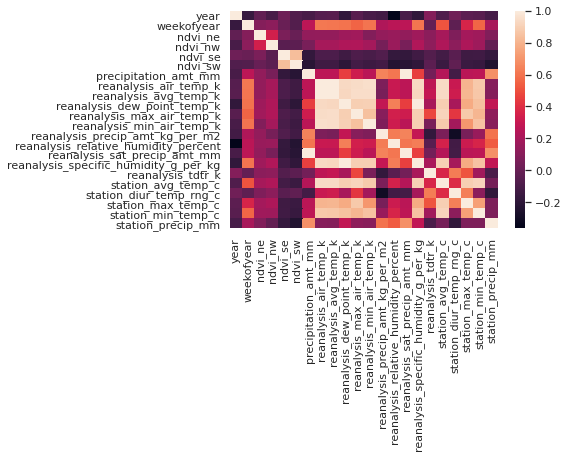

In [85]:
mtx_corr = filter_data.corr()
sns.heatmap(mtx_corr, xticklabels=mtx_corr.columns, yticklabels=mtx_corr.columns, annot=False)

In [86]:
repeated_pair=[]
for row in mtx_corr:
  i=0
  for feature in mtx_corr[row]:
    if (row != mtx_corr.columns[i]) & (feature >=0.95) & ([row, mtx_corr.columns[i]] not in repeated_pair):
      print('First variable: {var1}, Second variable: {var2}, Value: {val}'.format(var1=row, var2=mtx_corr.columns[i], val=feature))
      repeated_pair.append([mtx_corr.columns[i],row])
    i+=1



First variable: precipitation_amt_mm, Second variable: reanalysis_sat_precip_amt_mm, Value: 1.0
First variable: reanalysis_air_temp_k, Second variable: reanalysis_avg_temp_k, Value: 0.997679098612847
First variable: reanalysis_air_temp_k, Second variable: reanalysis_min_air_temp_k, Value: 0.9530881462741971
First variable: reanalysis_avg_temp_k, Second variable: reanalysis_min_air_temp_k, Value: 0.9513672725698957
First variable: reanalysis_dew_point_temp_k, Second variable: reanalysis_specific_humidity_g_per_kg, Value: 0.9989079658867076


We could see that there a bunch of features that have a strong correlation between them (we decided that a strong correlation would be a Pearson correlation coefficient more than 0.95). This pairs of features are the next ones:


*   ``precipitation_atm_mm`` and ``reanalysis_sat_precip_amt_mm`` with a correlation coefficient of 1.00
*   ``reanalysis_air_temp_k`` and ``reanalysis_avg_temp_k`` with a correlation coefficient of 0.9977
*   ``reanalysis_air_temp_k`` and ``reanalysis_min_air_temp_k`` with a correlation coefficient of 0.9530
*   ``reanalysis_avg_temp_k`` and ``reanalysis_min_air_temp_k`` with a correlation coefficient of 0.9514
*   ``reanalysis_dew_point_temp_k`` and ``reanalysis_specific_humidity_g_per_kg`` with a correlation coefficient of 0.9989



With a basic knowledge of the domain, we understand why that pairs of variables are strongly relationated.
* The first pair of variables are the total precipation each of them.
* The second pair represent the average air temperature and the mean air temperature, which it is the same.
* The third pair is also relationated but it hasn't the same meaning. One is the mean and the other is the minimum. Although, it has a very strong relation this three variables.
* The fourth pair is the same as the one before.
* At the fifth pair, we have investigated that the dew point temperature is influenced by the humidity. The dew point is the temperature the air needs to be cooled to (at constant pressure) in order to achieve a relative humidity (RH) of 100%.

![Dew-point-Temperature-for-22C-18C-and-16C-air-with-varying-humidity-Source-derived.png](https://www.researchgate.net/profile/Ken_Ruest/publication/44077697/figure/fig9/AS:668479581610007@1536389360856/Dew-point-Temperature-for-22C-18C-and-16C-air-with-varying-humidity-Source-derived.png)

---

We conclude that we could eliminate some features that are so redundant and not important. This features are ``reanalysis_sat_precip_amt_mm``, ``reanalysis_avg_temp_k`` and ``reanalysis_dew_point_temp_k``.

We eliminate this features from the normalized dataframe and we repeat the normalization of it.

In [87]:
filter_data = filter_data.drop(['reanalysis_sat_precip_amt_mm', 'reanalysis_avg_temp_k', 'reanalysis_dew_point_temp_k'], axis=1)
filter_data.head()

,year,weekofyear,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,reanalysis_max_air_temp_k,reanalysis_min_air_temp_k,reanalysis_precip_amt_kg_per_m2,reanalysis_relative_humidity_percent,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm
711,1,1,-0.26830,-0.123700,0.223757,0.176543,0.00,297.648571,299.3,296.1,20.7,72.577143,13.881429,2.028571,24.385714,5.557143,27.8,20.6,15.6
712,1,2,-0.07310,0.017200,0.214729,0.222443,0.00,297.648571,299.3,296.1,20.7,72.577143,13.881429,2.028571,24.385714,5.557143,27.8,20.6,15.6
713,1,3,-0.18635,0.002600,0.282100,0.289900,36.07,297.800000,299.5,296.5,20.2,78.942857,15.257143,2.171429,24.342857,5.957143,28.3,20.0,23.7
714,1,4,-0.18635,-0.178625,-0.015533,0.010250,0.00,297.728571,300.2,295.7,1.1,78.264286,15.061429,3.042857,24.528571,6.100000,27.8,20.6,10.2
715,1,5,-0.05350,-0.108000,0.236257,0.280414,0.00,297.560000,300.0,295.8,2.0,75.422857,14.390000,2.457143,24.628571,6.200000,28.9,20.0,1.8


In [88]:
norm_data = scaler.fit_transform(filter_data)
norm_data

array([[0.        , 0.        , 0.15333741, ..., 0.13253012, 0.35897436,
        0.07518072],
       [0.        , 0.01923077, 0.37031068, ..., 0.13253012, 0.35897436,
        0.07518072],
       [0.        , 0.03846154, 0.24442839, ..., 0.19277108, 0.28205128,
        0.11421687],
       ...,
       [1.        , 0.26923077, 0.27905297, ..., 0.3253012 , 0.5       ,
        0.14795181],
       [1.        , 0.28846154, 0.45356528, ..., 0.3253012 , 0.5       ,
        0.0539759 ],
       [1.        , 0.30769231, 0.41043739, ..., 0.60240964, 0.70512821,
        0.00144578]])

### Principal Component Analysis


The technique of **Principal Component Analysis** consists of a dimension reduction that projects on *k* dimensions less than the ones we have, by maximizing the variance and with the lost of information.

---
We pass as argument to the PCA algorithm the normalized dataset.

In [89]:
from sklearn.decomposition import PCA

pca = PCA()
pca_estimation = pca.fit_transform(norm_data)
pca_estimation.shape

(225, 19)

Plotting the cumulative variance of each PCA component , we could decide how many components 

In [90]:
exp_var_cumul = np.cumsum(pca.explained_variance_ratio_)

px.area(
    x=range(1, exp_var_cumul.shape[0] + 1),
    y=exp_var_cumul,
    labels={"x": "# Components", "y": "Explained Variance"}
)

We observe that the cumulative variance for having only two components is **not enough** and it is the same with more components, until it reaches the **even components**. The explained variance for seven components is **0.91**.

For this reason, we are going to **reduce the dimensionality** by *7 components*. This decision has advantages and disadvantages:

*   **Advantages:** the cumulative variance of having seven components allows us not having problem with lost of information and, by the way, obtaining better results.
*   **Disadvantages:** with seven components, we have six variables which can't be represented graphically through a 2-dimensional or a 3-dimensional space.

To resolve this problem we are going to have two matrices, a 7-dimensional matrix ``studied_pca`` (and the most important) would be used for the operations needed for resolve our problem, and the last one would be a 3-variable matrix ``plot3d_pca``. This is due to the need of represent our data and this would be the best because 3D is good for a quick lookup and it doesn't lose as much information as a 2D representation.



In [91]:
studied_pca = PCA (n_components = 7 ).fit_transform(norm_data)
plot3d_pca = PCA (n_components = 3 ).fit_transform(norm_data)

After that, we are going to plot our dataset represented in a 3-dimensional space.

In [92]:
total_var = pca.explained_variance_ratio_.sum() * 100

fig = px.scatter_3d(plot3d_pca, x = 0, y = 1, z = 2, size=filter_data['year'],
                    opacity=0.8, labels={'0': 'PC 1', '1': 'PC 2', '2': 'PC 3', 'size': 'year', 'color': 'year', 'text': 'week_id'},
                    title=f'Total Explained Variance: {total_var:.2f}%',
                    text=filter_data.index, color=filter_data['year'])
fig.show()

This graph is grouped by year with colors and sizes.

## Outlier identification

The outlier detection is done by the DBSCAN algorithm. This technique is based on the theory that groups are defined by high-density areas. Low-density areas separate groups. The central points of a group have a neighborhood area for a given radius that has at least a minimum number of points, i.e. their neighborhood area exceeds a certain threshold. We are going to consider MinPts as 3 

### Setting parameters


1.   Computation of the distance matrix



In [93]:
#Compute the similarity matrix
dist = sklearn.neighbors.DistanceMetric.get_metric('euclidean')
matsim = dist.pairwise(studied_pca)

#Visualization
fig = px.imshow(matsim)
fig.show()

At this point, we can see in the image of the distance matrix representation, a pattern that could match the different weeks of different years on the same season.

2.   Computation of the distance from each point to its neighbors (3)

In [94]:
minPts=3

A = kneighbors_graph(studied_pca, minPts, include_self=False)
Ar = A.toarray()

seq = []
for i,s in enumerate(studied_pca):
    for j in range(len(studied_pca)):
        if Ar[i][j] != 0:
            seq.append(matsim[i][j])
            
seq.sort()

In [95]:
fig = px.line(x=np.arange(0, len(seq), 1), y=seq)
fig.show()

In DBSCAN, the epsilon is normally chosen at the elbow of this graphic. For this reason, we are going to trying results of how DBSCAN works with different epsilon from the beggining of the elbow and to the final. This goes from 0.6 to 0.9.

In [96]:
results = []
for eps in np.arange(0.6, 0.9, 0.05):
  db = DBSCAN(eps, min_samples=minPts).fit(studied_pca)
  core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
  core_samples_mask[db.core_sample_indices_] = True
  labels = db.labels_
  n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
  n_outliers = list(labels).count(-1)
  #print ("%6.2f, %d, %d" % (eps, n_clusters_, n_outliers))
  results.append([eps, n_clusters_, n_outliers])

#print results
from tabulate import tabulate
print(tabulate(results, headers = ("eps", "clusters", "outliers")))

  eps    clusters    outliers
-----  ----------  ----------
 0.6            1           5
 0.65           1           2
 0.7            1           2
 0.75           1           2
 0.8            1           2
 0.85           1           1
 0.9            1           1


### Execution

In [97]:
db = DBSCAN(eps=0.65, min_samples=minPts).fit(studied_pca)
labels = db.labels_
labels

array([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0, -1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0, -1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0])

### Visualization

In [98]:
fig = px.scatter_3d(plot3d_pca, x = 0, y = 1, z = 2,
                    opacity=0.8, labels={'0': 'PC 1', '1': 'PC 2', '2': 'PC 3', 'color': 'outlier', 'text': 'week_id'},
                    title=f'Total Explained Variance: {total_var:.2f}%',
                    text=filter_data.index, color=labels)

fig.show()

In [99]:
filter_data['dbscan_group'] = labels

filter_data[filter_data['dbscan_group'] == -1]

,year,weekofyear,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,reanalysis_max_air_temp_k,reanalysis_min_air_temp_k,reanalysis_precip_amt_kg_per_m2,reanalysis_relative_humidity_percent,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm,dbscan_group
749,1,39,0.033475,-0.06745,0.225257,0.2332,245.73,299.798571,302.9,297.7,254.95,85.330000,18.645714,2.542857,27.228571,6.057143,33.9,23.3,158.2,-1
780,2,17,-0.092950,-0.24980,0.101233,0.1060,234.13,298.917143,301.6,296.4,98.50,81.751429,16.964286,3.585714,26.785714,6.885714,32.8,22.8,207.5,-1


In [100]:
other_rows = 0

for week_prec in filter_data['precipitation_amt_mm']:
  if (week_prec >= filter_data.at[749, 'precipitation_amt_mm']/2) and (week_prec >= filter_data.at[780, 'precipitation_amt_mm']/2):
    other_rows+=1

other_rows

9

There two possible outliers in our first year and in our second year, in the 39th and the 17th week of the year respectively. The anomalies in this data is the excesive precipation. Comparating precipitation of many weeks with this data, we saw that this precipitation is the double against the majority of all other weeks. Only 9 weeks of all the dataset are closer to this outliers, but not at all.

The conclusion is that we are going to delete these rows to prevent other problems, like dispersion or difficulties to interpret clustering classification.

After that we have to delete these rows of all of our useful data structures.

In [101]:
filter_data = filter_data.drop([749, 780], axis=0)
norm_data = scaler.fit_transform(filter_data)
studied_pca = PCA (n_components = 7 ).fit_transform(norm_data)
plot3d_pca = PCA (n_components = 3 ).fit_transform(norm_data)

## Clustering by K-means

At this point, next thing to do is K-means. The k-means algorithm is based on the idea that a central point can represent a cluster, this point is called centroid.

Usually this point is the mean or median of a group of points and therefore may not be an element of the set to be analyzed.

Clustering algorithms are used principally for finding groups elements in which the elements of this groups are more similar to the elements of the same group than the elements of other groups.

K-means is good in efficiency, but has some disadvantages like we need to determine the number of clusters we want, and it doesn't behave so well with different shapes.

---

### Setting parameters

In [102]:
# PARAMETERS
init = 'random' # initialization method 

# To run 10 times with different random centroids 
# to choose the final model as the one with the lowest SSE
iterations = 10

# Maximum number of iterations for each single run
max_iter = 300 

# Controls the tolerance with regard to the changes in the 
# within-cluster sum-squared-error to declare convergence

tol = 1e-04 

 # Random seed
random_state = 0

The election of **k** will depend on the distortion (**SSE**) and **silhouette** from k = 2 to k = 12.

In [103]:
distortions = []
silhouettes = []

for i in range(2, 12):
    km = KMeans(i, init, n_init = iterations ,max_iter= max_iter, tol = tol,random_state = random_state)
    labels = km.fit_predict(studied_pca)
    distortions.append(km.inertia_)
    silhouettes.append(metrics.silhouette_score(studied_pca, labels))

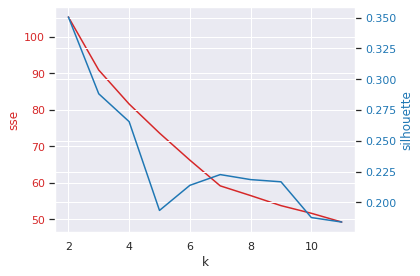

In [104]:
x = [i for i in range(2,12)]
fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('k')
ax1.set_ylabel('sse', color=color)
ax1.plot(x, distortions, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('silhouette', color=color)  # we already handled the x-label with ax1
ax2.plot(x, silhouettes, color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

The value of k is choosen taking into account the point with the highest silhouette and, at the same time, the lowest SSE value. Seeing the graph, the best k could be 4, because it is the point that has more silhouette instead we choose 7. This point have less silhoutte and the difference of SSE isn't so much. The SSE is not the lowest one, but if we want to have less SSE we have to manage more clusters.

### Execution

In [105]:
#@title Number of clusters {run: "auto"}
k = 4 #@param { type: "slider", min: 2, max: 12, step: 1}

Executing the clustering

In [106]:
print ("Number of clusters", k)
km = KMeans(k, init, n_init = iterations ,
            max_iter= max_iter, tol = tol, random_state = random_state)

studied_km = km.fit_predict(studied_pca)

Number of clusters 4


This values are the next ones:

In [107]:
print("Silhouette Coefficient: %0.3f"
      % metrics.silhouette_score(studied_pca, studied_km))
      
print('Distortion: %.2f' % km.inertia_)

Silhouette Coefficient: 0.266
Distortion: 81.55


### Visualization

In [108]:
fig = px.scatter_3d(plot3d_pca, x = 0, y = 1, z = 2,
                    opacity=0.9, labels={'0': 'PC 1', '1': 'PC 2', '2': 'PC 3', 'color': 'cluster', 'text': 'week_id'},
                    text=filter_data.index, color=km.labels_)

fig.show()

We will execute K-means with the K-means++ initialization type, to observe if there is a significant difference.

In [109]:
km_plus = KMeans(k, 'k-means++', n_init = iterations,
            max_iter = max_iter, tol = tol, random_state = random_state)

studied_km_plus = km_plus.fit_predict(studied_pca)

In [110]:
fig = px.scatter_3d(plot3d_pca, x = 0, y = 1, z = 2,
                    opacity=0.9, labels={'0': 'PC 1', '1': 'PC 2', '2': 'PC 3', 'color': 'cluster', 'text': 'week_id'},
                    text=filter_data.index, color=km_plus.labels_)

fig.show()

### Interpretation

In [111]:
filter_data['kmeans_group'] = km.labels_
filter_data['kmeans_plus_group'] = km_plus.labels_

First of all, to try to analyse this results and the formed clusters, we are going to extract some important features of our dataset like the temperature (``station_avg_temp_c``), the humidity (``reanalysis_relative_humidity_percent``) and the precipitation(``precipitation_amt_mm``).



In [112]:
res = filter_data[['station_avg_temp_c', 'precipitation_amt_mm', 'reanalysis_relative_humidity_percent', 'kmeans_group']].groupby('kmeans_group')
res.describe()

station_avg_temp_c             ... reanalysis_relative_humidity_percent           
                          count       mean  ...                                  75%        max
kmeans_group                                ...                                                
0                          31.0  26.193548  ...                            77.705714  78.667143
1                          35.0  25.936735  ...                            80.533571  83.952857
2                         107.0  28.341121  ...                            79.962857  84.335714
3                          50.0  24.770857  ...                            76.785714  83.055714

[4 rows x 24 columns]

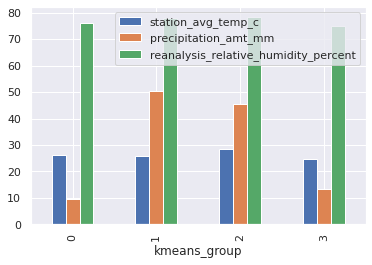

In [113]:
res = res.mean()
res.plot(kind='bar', legend=True)

We observe that the clusters are organized by the precipitation of the elments. Thus, we could deduce that precipitation causes a diferentitation between the data. We are going to see now all the precipitation variables of the dataset if the hypothesis is correct.

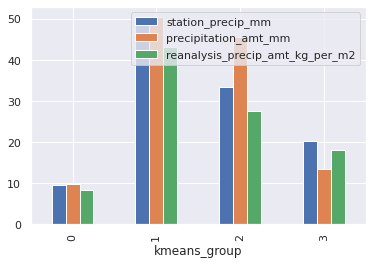

In [114]:
res = filter_data[['station_precip_mm', 'precipitation_amt_mm', 'reanalysis_precip_amt_kg_per_m2', 'kmeans_group']].groupby('kmeans_group').mean()
res.plot(kind='bar', legend=True)

Seeing this other variables related to the precipitation, we can confirm that there is a segregation by amount of precipitation among this clusters. There is a clear distinction between elements of differents groups.

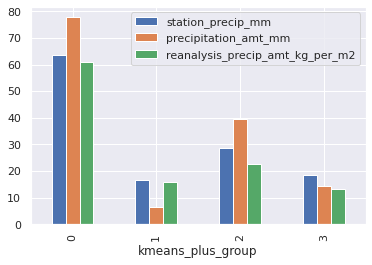

In [115]:
res = filter_data[['station_precip_mm', 'precipitation_amt_mm', 'reanalysis_precip_amt_kg_per_m2', 'kmeans_plus_group']].groupby('kmeans_plus_group').mean()
res.plot(kind='bar', legend=True)

If we plot the graphic with the precipitation values grouped by the K-means++ initialization of the centroids, we can look that the same behaviour have happened. For this reason, we decide to treat the results obtained from this two centroid initialization types indifferently.

---
We searched that there is also a diferentation with the vegetation factor.

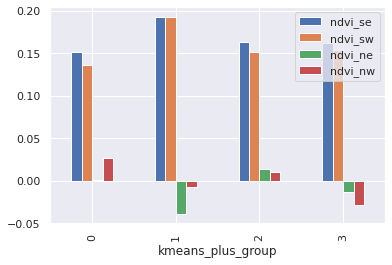

In [116]:
res = filter_data[['ndvi_se', 'ndvi_sw', 'ndvi_ne', 'ndvi_nw', 'kmeans_plus_group']].groupby('kmeans_plus_group').mean()
res.plot(kind='bar', legend=True)

As we see here in this graphic, that represent the mean of each pixel of the sattelite vegetation, there are values a little different in each of the cluster. It is more clear in the columns of ``ndvi_ne`` and ``ndvi_nw``. There are not to much difference, but we don't know the scale of this variable.

At this point, we can conclude that k-means had classificated our data by the difference in precipation and vegetation. It is very curious that k-means classificated data by this variable, because this factors could became determinant to the prolifaration of Dengue mosquito. Our experience says that sites that has a stable high temperature, much precipitation and a lot of vegetation, is a good habitat for the mosquito. We have that temperature is high because we see that most of the entries of the database are not below 20 degrees, and stable because there isn't too much deviation in the data and the clustering algorithm hasn't be able to group by temperature.

## Hierarchical Clustering Algorithm

The hierarchical clustering algorithms are distinguished by generating as a result, a structure of
groups organized in the form of a hierarchical tree. This tree, called the dendrogram, is a faithful reflection of how the clusters relate to each other.

---

Ending with the analysis of this Dengue investigation, we are going to execute a hierarchical clustering algorithm to see how our data is organized. As wee in k-means, there are groups of data that have a differentation in precipitation and vegetation, but the objective with this algorithm is to see the structure.

We calculate the similarity matrix of our data first of all, because this algorithm is based entirely.

In [117]:
matsim = dist.pairwise(studied_pca)

### Execution

For the intercluster distance, we are going to prove all of them to see which of them is the best.



1.   Single-link



/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: ClusterWarning:

scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix



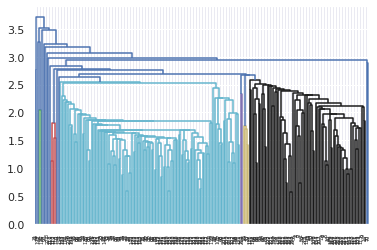

<Figure size 432x288 with 0 Axes>

In [118]:
clusters_single = cluster.hierarchy.linkage(matsim, method = 'single')
cluster.hierarchy.dendrogram(clusters_single)
f = plt.figure()
plt.show()

2.   Complete-link

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: ClusterWarning:

scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix



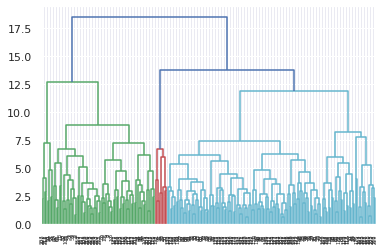

<Figure size 432x288 with 0 Axes>

In [119]:
clusters_complete = cluster.hierarchy.linkage(matsim, method = 'complete')
cluster.hierarchy.dendrogram(clusters_complete)
f = plt.figure()
plt.show()

3.   Average-link

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: ClusterWarning:

scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix



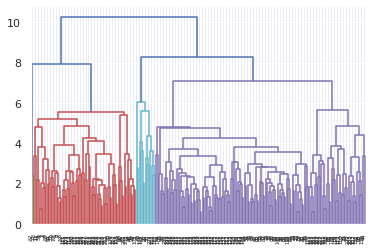

<Figure size 432x288 with 0 Axes>

In [120]:
clusters_average = cluster.hierarchy.linkage(matsim, method = 'average')
cluster.hierarchy.dendrogram(clusters_average)
f = plt.figure()
plt.show()

Observing all the dendograms we have seen that the intercluster distance that give us an apparently better results, with a well organized structure, is the **complete-link** distance.

After that, we have to determine the cut in order that the groups created have other clusters insides them very similar.

In [121]:
#@title Threshold {run: "auto"}
cut  = 9 #@param { type: "slider", min: 1, max: 40, step: 0.5}

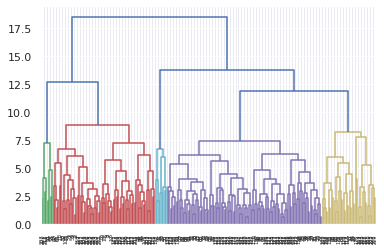

<Figure size 432x288 with 0 Axes>

In [122]:
cluster.hierarchy.dendrogram(clusters_complete, color_threshold=cut)
f = plt.figure()
plt.show()

In [123]:
labels = cluster.hierarchy.fcluster(clusters_complete, cut , criterion = 'distance')

labels

array([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 5, 2, 5, 5, 5, 3, 3,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 3, 2, 2, 2, 5, 3, 2, 2, 2, 2, 2, 1, 1, 1, 1, 2, 2, 2, 2, 5, 5,
       5, 5, 5, 5, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 3, 4, 4, 4, 4, 4, 5, 5, 2, 5, 2, 5, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 5, 2, 5, 5, 5, 5, 2, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 5, 5, 5,
       2, 2, 2, 2, 2, 2, 5, 5, 5, 5, 5, 5, 5, 2, 5, 5, 5, 2, 5, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 3,
       4, 4, 4, 2, 2, 2, 2, 2, 2, 1, 2, 1, 2, 1, 2, 2, 2, 2, 2, 2, 1, 5,
       2, 2, 5], dtype=int32)

In [124]:
# If there is a cluster that is -1 is considered as an outlier

n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
print('Estimated number of clusters: %d' % n_clusters_)
print("Silhouette Coefficient: %0.3f"
      % metrics.silhouette_score(norm_data, labels))

Estimated number of clusters: 5
Silhouette Coefficient: 0.156


With a level 9 cut with a full link results in 5 groups which have elements that are very similar to each other. Silhouette is not the better, but if we go up in the dendogram we are going to merge clusters that are not very alike.

### Visualization

In [125]:
fig = px.scatter_3d(plot3d_pca, x = 0, y = 1, z = 2,
                    opacity=0.9, labels={'0': 'PC 1', '1': 'PC 2', '2': 'PC 3', 'color': 'cluster', 'text': 'week_id'},
                    text=filter_data.index, color=labels)

fig.show()

If we take the statistics that we prove with the k-means, we will obtain this:

In [126]:
filter_data['hier_group'] = labels

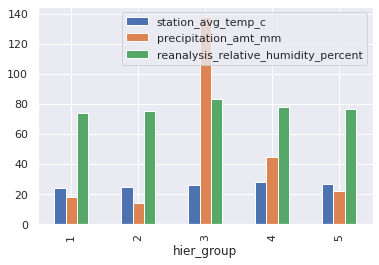

In [127]:
res = filter_data[['station_avg_temp_c', 'precipitation_amt_mm', 'reanalysis_relative_humidity_percent', 'hier_group']].groupby('hier_group').mean()
res.plot(kind='bar', legend=True)

As we saw with k-means, that clusters are identified by the amount of precipitation.

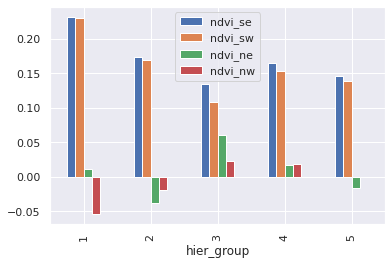

In [128]:
res = filter_data[['ndvi_se', 'ndvi_sw', 'ndvi_ne', 'ndvi_nw', 'hier_group']].groupby('hier_group').mean()
res.plot(kind='bar', legend=True)

With the vegetation we can see also a difference, but not to much as the precipitation and not with the same scale.